In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas_to_pybeh as pb
from cmlreaders import CMLReader, get_data_index
from plotting import *

In [2]:
# 1. If I want all FR1 and pyFR subjects
df = get_data_index("r1")
FR1_subs=df[df['experiment']=='catFR1']['subject'].unique() # all FR1 subjects
exp = 'catFR1' 

FR_subs=[]
FR_subs = list(FR1_subs)
print('Total number of catFR subjects: ',len(FR_subs))
np.save('catfrsubs',FR1_subs)

Total number of catFR subjects:  243


In [3]:
evs = []
from tqdm.notebook import tqdm
for i, sub in enumerate(tqdm(FR_subs)):
    try:
#     print(sub, str(i/len(both)*100) + "% Done")
        df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
        sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
        for sess in sessions:
            reader = CMLReader(sub, exp, sess)
            evs.append(reader.load('events'))
    except:
        print(sub,exp)
evs = pd.concat(evs)
word_evs = evs[evs.type =='WORD']

R1221P catFR1



In [45]:
zscore = (word_evs.groupby(['subject', 'session', 'list']).recalled.mean().groupby(['subject', 'session']).mean().groupby('subject').mean()*12).reset_index()
zscore['subject'] = zscore.subject.apply(lambda x: int(x[2:5]))
zscore.set_index('subject',inplace=True)
ages = pd.read_csv('catFR1_subject_ages.csv')
ages = ages.dropna(subset=['Age at Implant (calculated)']).set_index('Subject Number')
zscore['age']=ages['Age at Implant (calculated)']
zscore['recalled'] = zscore.recalled
zscore['recalled'].mean()
zscore.dropna(inplace=True)
zscore.to_csv('cat_age.csv')

r(196) = -0.34329045150921766, p = 7.374388909851519e-07


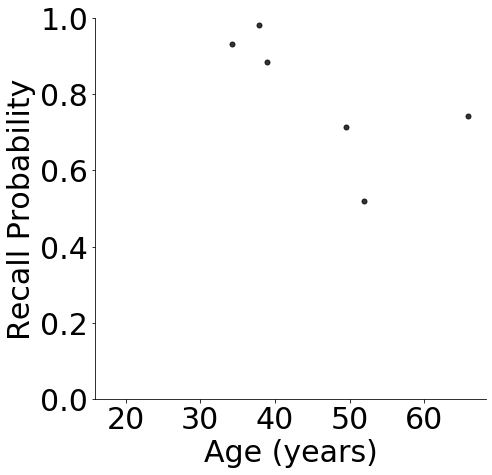

In [46]:
set_axes(fontsize=30, ylim=[0,1])

sns.regplot(data=zscore, x='age', y = 'recalled', color = 'black', scatter_kws=dict(s = 25), line_kws=dict(linewidth=5))
zscore.dropna(inplace=True)
n=zscore.shape[0]
r,p = scipy.stats.pearsonr(zscore['age'], zscore['recalled'])
_=plt.xlabel('Age (years)')
_=plt.ylabel('Recall Probability')
print('r({}) = {}, p = {}'.format(n-2,r,p))
plt.savefig('catFR1_age.pdf', bbox_inches='tight')

In [47]:
np.save('CATvAge', [r,n])

In [ ]:
def get_age_group(age):
    if 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age <50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    elif 60 <= age < 70:
        return '60-69'
    else:
        return np.nan

In [ ]:
zscore['age_group'] = zscore.age.apply(get_age_group)
zscore.dropna(subset=['age_group'], inplace=True)

In [54]:
def get_zscore(age_group, score, norms):
    norms = norms[norms.age_group == age_group]
    zscore = (score - norms['mean'].values[0])/norms['std'].values[0]
    return zscore

In [57]:
norms = pd.read_csv('catfr_mturk_norms.csv')
zscore_by_age = zscore.apply(lambda x: get_zscore(x.age_group, x.recalled, norms), axis=1)


-1.4636365365213466

In [61]:
zscore_mean = zscore_by_age.mean()
zscore_std = zscore_by_age.std()
zscore_n = zscore_by_age.count()
np.save('cathospitalzscore', [zscore_mean, zscore_std, zscore_n])

In [33]:
mturk_cat_five = np.load('five_final_catfr.npy', allow_pickle = True)
mt_five_mean = mturk_cat_five.mean()
mt_five_std = mturk_cat_five.std()
first_five = word_evs[word_evs.list < 6]
five_zscore = first_five.groupby(['subject', 'session', 'list']).recalled.mean().groupby(['subject', 'session']).mean().groupby('subject').mean().reset_index()
five_zscore['zscore'] = (five_zscore.recalled - mt_five_mean)/mt_five_std

In [36]:
np.save('cat_five_zscore', five_zscore.zscore)

0.3128547640267232